# GAN(Generative Adversarial Network) 빌딩 연습

생성모형(generator)와 판별모형(discriminator) 두 신경망이 서로 경쟁을 통해 학습하는 신경망 모형이다. 서로 적대적으로 경쟁하며 학습하기 때문에 붙은 이름이다.

판별 모형은 주어진 데이터가 데이터셋의 오리지널 데이터로부터 추출되었는지, 아니면 생성기가 만들어 낸 가짜 데이터인지를 구분하는 것이고,

생성 모형은 판별 모형이 구분할 수 없도록 진짜 같은 가짜 데이터를 생성하는 것이다. 

생성 모형이 진짜 같은 가짜 데이터를 만든다면 판별 모형은 가짜 데이터를 진짜라고 판별할 확률이 높아질 것이다. 

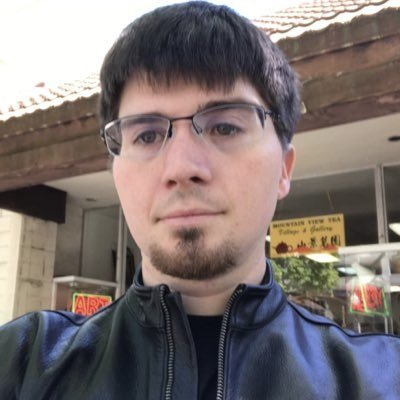 **_GAN FATHER_ 구글의 Ian Goodfellow : https://www.bloter.net/newsView/blt201806080001**

---
##### 알고리즘



##### 12.8.3 GAN 실습
GAN 알고리즘으로 진짜같은 손글씨를 생성하는 실습을 해본다.

# Random seed setting and Load Data, Libraries

일관된 결과를 위해 random seed를 0으로 고정한다.


In [1]:
import numpy as np
import tensorflow as tf
import keras

np.random.seed(0)
tf.random.set_seed(0)

# version check
print(np.__version__)
print(tf.__version__)
print(keras.__version__)

1.22.4
2.9.1
2.9.0


In [2]:
# data load
# 손글씨 데이터를 데려온다: 오직 트레이닝 피처 데이터만을 사용하기 때문에 이만 데려온다.

from tensorflow.keras import datasets
(X_raw, _), (_, _) = datasets.mnist.load_data()

## variance setting for learning

이미지 데이터 개수를 n_img라고 저장하고, 학습 단계는 책에서 3000회로 하였다. 배치는 100씩 진행되도록 한다. (약 2시간 소요라고 하였다)

In [3]:
n_img = X_raw.shape[0]
n_img

60000

In [4]:
epoch = 3000
n_batch = 100

## Preprocessing data

reshape로 차원을 (이미지 데이터 개수, 28, 28, 1) 로 변경하도록 한다. 

차원을 변경하는 이유는 합성곱 신경망을 사용하기 위함이다. Conv2D를 사용하기 위해서는 인풋 데이터가 4개의 차원을 가지고 있어야 하기 때문이다.

또한 기존 데이터는 0~255의 범위(grey톤의 값)를 가지고 있는데 이를 -1부터 1의 범위로 변경하여 학습에 용이하도록 한다.

scale_c를 기존 데이터 포인트 최댓값의 절반으로 설정한다. (기존데이터-scale_c)/scale_c하면 -1부터 1까지의 값을 가지게 된다.

real_1은 원소 값이 1인 100 * 1 크기의 벡터이다. 이는 원본 손글씨 데이터의 타깃 데이터가 된다.

즉, 원본 데이터 손글씨가 1, 가짜데이터면 0을 가지게 되는데, real_1은 손글씨 데이터에 대한 타깃 데이터이므로 모두 1로 라벨링 된다. 

반대로 fake_0 은 가짜 손글씨 데이터에 대한 타깃 데이터이다. 가짜 데이터이므로 모두 0을 갖는다.


In [5]:
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c

real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

# Building Model

## Deep Learning Libraries

In [6]:
from tensorflow.keras.models import Sequential, Model  # 입력과 출력층 모델만들기
from tensorflow.keras.layers import Input, Reshape     # 입력층은 Input함수를 사용
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout     # 신경망 층 추가
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D       # 출력층의 업샘플링(차원 늘리기)
from tensorflow.keras.layers import Conv2D, MaxPool2D  # 합성곱 층을 추가, 2차원이기 때문에 2D를 사용
from tensorflow.keras.layers import Activation         # 활성화함수
from tensorflow.keras.layers import LeakyReLU

## Generator
주석 때문에 지저분해지는 경향이 있어서 후에 헷갈려서 다시 볼때만 편하기 위해 따로 적었다.

```
input_layer1 = Input(shape = (100, ))    # input layer (100개의 데이터)

x1 = Dense(64*7*7)(input_layer1)         # Dense로 67*7*7개의 아웃풋 생성: 우리가 만들려는 텐서의 형태와 일치시키기 위한 형태.
x1 = BatchNormalization()(x1)            # Dense를 통해 출력된 데이터 표준화
x1 = Activation(LeakyReLU(0.3))(x1)      # 데이터에 음수가 있기 때문에 LeakyReLu 사용
x1 = Reshape((7, 7, 64))(x1)             # 출력 데이터 텐서 형태 변형
x1 = UpSampling2D()(x1)                  # 이미지 크기 키우기
x1 = Conv2D(32, kernel_size = (3, 3), padding = 'same')(x1) # 합성곱: 아웃풋은 32개가 되도록 하며, 차원은 보존
x1 = BatchNormalization()(x1)            # 표준화
x1 = Activation(LeakyReLU(0.3))(x1)      # 마찬가지로 활성화함수는 LeakyReLu 사용
x1 = UpSampling2D()(x1)                  # 이미지 크기 키우기

output_layer1 = Conv2D(1, kernel_size = (3, 3), padding = 'same', activation = 'tanh')(x1) # 출력층 설정, 이미지가 한개 출력되어야 하므로 1.
generator = Model(input_layer1, output_layer1) # 인풋층과 아웃풋 층을 매개 변수로 모델링
generator.summary()
```

In [7]:
# generator

input_layer1 = Input(shape = (100, ))

x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7, 7, 64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size = (3, 3), padding = 'same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)

output_layer1 = Conv2D(1, kernel_size = (3, 3), padding = 'same', activation = 'tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                           

2022-06-29 05:11:49.330424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Discriminator

```
input_layer2 = Input(shape = (28, 28, 1))              # 손글씨 데이터는 (28, 28, 1) 차원이므로

x2 = Conv2D(64, kernel_size = (5, 5), padding = 'same')(input_layer2) # 합성곱 수행
x2 = Activation(LeakyReLU(0.3))(x2)                    # 활성화 함수: LeakyReLU
x2 = Dropout(0.25)(x2)                                 # 0.25%의 데이터는 사용하지 않는 의미
x2 = Conv2D(128, kernel_size = (3, 3), padding = 'same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2) # 데이터 펼침

output_layer2 = Dense(1, activation = 'sigmoid')(x2)   # 아웃풋 층을 sigmoid 함수를 이용해 출력
discriminator = Model(input_layer2, output_layer2)     # 판별 모형 설정
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # 모형 컴파일
discriminator.trainable = False                        # False = 오차 역전법으로 가중치 업데이트를 통해 학습하지 않는다는 의미
discriminator.summary()
```

discriminator.trainable = False  의 경우 딥러닝에서는 입력 데이터를 통해 딥러닝을 진행하면서 오차 역전법으로 가중치를 갱신한다.

한 에포크에서도 미니 배치 데이터를 이용해 학습이 진행될수록 정확도가 지속적으로 상승하도록 하는데, 이 옵션을 금지한다.

우리는 하나의 데이터 셋을 이용해 학습 정확도를 향상시키는 것이 목적이 아니기 때문이다.

In [8]:
# discriminator

input_layer2 = Input(shape = (28, 28, 1))

x2 = Conv2D(64, kernel_size = (5, 5), padding = 'same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size = (3, 3), padding = 'same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)

output_layer2 = Dense(1, activation = 'sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 activation_3 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0   

## GAN

두 모형을 연결시킨다. 인풋은 100개의 데이터이다. 아웃풋을 설정하는데, 아웃풋은 생성자를 통해 이미지를 생성한 후 판별하는 형태이다.


In [9]:
input_gan = Input(shape = (100, ))

output_dis = discriminator(generator(input_gan))

gan = Model(input_gan, output_dis)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         348161    
                                                                 
 model_1 (Functional)        (None, 1)                 175873    
                                                                 
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


# Learning

##### 변수명
    loss_disc_real: 실제 데이터를 이용해 판별했을 때 손실
    loss_disc_fake: 가짜 데이터를 이용해 판별했을 때 손실
    loss_disc_avg: 위 둘의 손실 평균
    loss_gan: GAN 모형 손실
    acc_disc_real: 실제 데이터를 이용해 판별했을 때 정확도
    acc_disc_fake: 가짜 데이터를 이용해 판별했을 때 정확도
    acc_disc_avg: 위 둘의 정확도 평균
    acc_gan: GAN 모형 정확도

In [10]:
# epoch별 손실 및 정확도를 담을 변수 설정

# 테스트를 위해 3회만 해보기로 한다.
# 여기서 epoch 설정을 해야 뒤에서 length가 맞으니 주의
epoch = 3

loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

In [11]:
for i in range(0, epoch):
    # real data discriminating
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # generating fake data and discriminating
    fake = np.random.normal(0, 1, size = (n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # average of discrimination loss and accuracy
    loss_disc_avg_ith = np.add(res_real[0], res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1], res_fake[1])*0.5
    
    # GAN results
    res_gan = gan.train_on_batch(fake, real_1)
    
    # accuracy and loss
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    # results score
    print('epoch: %d'%i,
         ' 판별 손실 평균: %.4f'%loss_disc_avg_ith,
         ' 판별 정확도 평균: %.4f'%acc_disc_avg_ith,
         ' 생성 손실: %.4f'%res_gan[0],
         ' 생성 정확도: %.4f'%res_gan[1])

4/4 [==============================] - 0s 9ms/step
epoch: 0  판별 손실 평균: 0.8736  판별 정확도 평균: 0.4650  생성 손실: 0.0525  생성 정확도: 1.0000
4/4 [==============================] - 0s 10ms/step
epoch: 1  판별 손실 평균: 0.5891  판별 정확도 평균: 0.5000  생성 손실: 0.2958  생성 정확도: 1.0000
4/4 [==============================] - 0s 11ms/step
epoch: 2  판별 손실 평균: 0.2544  판별 정확도 평균: 1.0000  생성 손실: 2.9411  생성 정확도: 0.0000


된다. 코드 돌아간다. 

# Results (generated values checking)

## Loss and Accuracy gGraph

3개만 가지고 그릴수 있도록 `n = len(epo)` 를 추가했다.

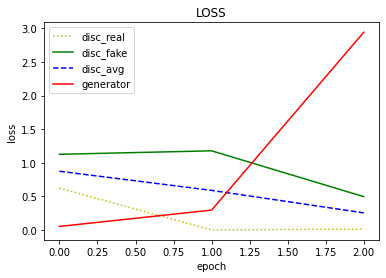

In [12]:
import matplotlib.pyplot as plt
epo = np.arange(0, epoch)
n = len(epo)
plt.figure()
plt.plot(epo, loss_disc_real[0:n], 'y:', label = 'disc_real')
plt.plot(epo, loss_disc_fake[0:n], 'g-', label = 'disc_fake')
plt.plot(epo, loss_disc_avg[0:n], 'b--', label = 'disc_avg')
plt.plot(epo, loss_gan[0:n], 'r', label = 'generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

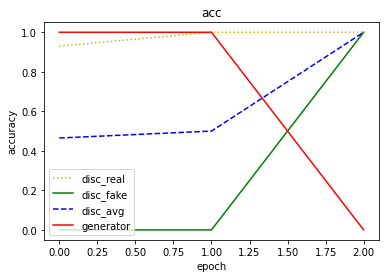

In [13]:
# import matplotlib.pyplot as plt
epo = np.arange(0, epoch)
n = len(epo)

plt.figure()
plt.plot(epo, acc_disc_real[0:n], 'y:', label = 'disc_real')
plt.plot(epo, acc_disc_fake[0:n], 'g-', label = 'disc_fake')
plt.plot(epo, acc_disc_avg[0:n], 'b--', label = 'disc_avg')
plt.plot(epo, acc_gan[0:n], 'r', label = 'generator')
plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## fake data checking
epoch = 3의 데이터이다. 아직까지는 정말 알아볼 수 없는 상태이다.

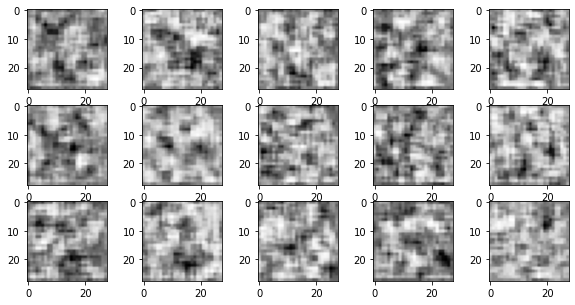

In [14]:
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize = (10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap = 'Greys')
plt.show()

# epoch = 5000 실험

In [ ]:
# epoch별 손실 및 정확도를 담을 변수 설정

epoch = 5000

loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

In [ ]:
import time
start = time.time()  # 시작 시간 저장

for i in range(0, epoch):
    # real data discriminating
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # generating fake data and discriminating
    fake = np.random.normal(0, 1, size = (n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # average of discrimination loss and accuracy
    loss_disc_avg_ith = np.add(res_real[0], res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1], res_fake[1])*0.5
    
    # GAN results
    res_gan = gan.train_on_batch(fake, real_1)
    
    # accuracy and loss
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    # results score
    print('epoch: %d'%i,
         ' 판별 손실 평균: %.4f'%loss_disc_avg_ith,
         ' 판별 정확도 평균: %.4f'%acc_disc_avg_ith,
         ' 생성 손실: %.4f'%res_gan[0],
         ' 생성 정확도: %.4f'%res_gan[1])

end = time.time()
print("Working TIme: %.4f"%(end-start))

된다. 코드 돌아간다. 

# Results (generated values checking)

## Loss and Accuracy gGraph

3개만 가지고 그릴수 있도록 `n = len(epo)` 를 추가했다.

In [ ]:
import matplotlib.pyplot as plt
epo = np.arange(0, epoch)
n = len(epo)
plt.figure()
plt.plot(epo, loss_disc_real[0:n], 'y:', label = 'disc_real')
plt.plot(epo, loss_disc_fake[0:n], 'g-', label = 'disc_fake')
plt.plot(epo, loss_disc_avg[0:n], 'b--', label = 'disc_avg')
plt.plot(epo, loss_gan[0:n], 'r', label = 'generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
epo = np.arange(0, epoch)
n = len(epo)

plt.figure()
plt.plot(epo, acc_disc_real[0:n], 'y:', label = 'disc_real')
plt.plot(epo, acc_disc_fake[0:n], 'g-', label = 'disc_fake')
plt.plot(epo, acc_disc_avg[0:n], 'b--', label = 'disc_avg')
plt.plot(epo, acc_gan[0:n], 'r', label = 'generator')
plt.title('acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## fake data checking
epoch = 5000 학습 이후 생성된 데이터이다!

In [ ]:
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize = (10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap = 'Greys')
plt.show()